In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from a5_utils import *

1 b

In [2]:
def compute_disparity(f,T,px,pz):
    x1 = (f * px) / pz
    x2 = (f*(px - T)) / pz
    disparity = x1 - x2
    return disparity

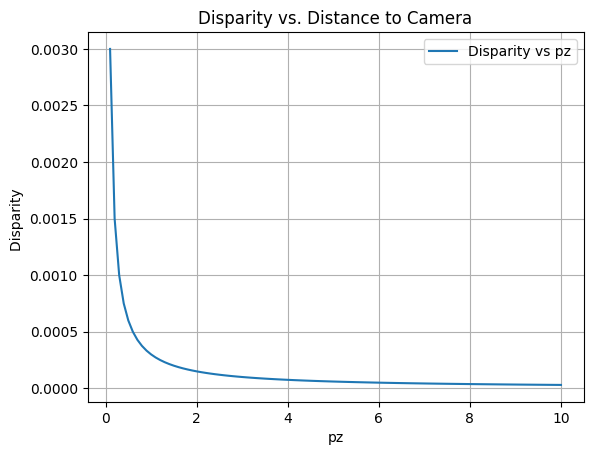

In [3]:
f = 0.0025
T = 0.12

px = 1
pz = np.linspace(0.1, 10, 100)

d = compute_disparity(f,T,px,pz)

plt.plot(pz, d, label='Disparity vs pz')
plt.xlabel('pz')
plt.ylabel('Disparity ')
plt.title('Disparity vs. Distance to Camera')
plt.legend()
plt.grid(True)
plt.show()


1 c

In [4]:
f = 2.5 / 1000 
T = 12 / 100   
pixel_left = 550
pixel_right_1 = 300
pixel_right_2 = 540

d_1 = (pixel_left - pixel_right_1) * 7.4e-6 
d_2 = (pixel_left - pixel_right_2) * 7.4e-6  

Z_1 = (f * T) / d_1
Z_2 = (f * T) / d_2

print("Distance for the first case:", Z_1, "meters")
print("Distance for the second case:", Z_2, "meters")

Distance for the first case: 0.16216216216216214 meters
Distance for the second case: 4.0540540540540535 meters


1 d

In [5]:
def NCC(patch1, patch2):
    mean_patch1 = np.mean(patch1)
    mean_patch2 = np.mean(patch2)
    
    numerator = np.sum((patch1 - mean_patch1) * (patch2 - mean_patch2))
    denominator = np.sqrt(np.sum((patch1 - mean_patch1)**2) * np.sum((patch2 - mean_patch2)**2))
    
    return numerator / denominator if denominator != 0 else 0

In [6]:
def find_disparity(img_left, img_right, patch_size):
    h, w = img_left.shape
    half_patch = patch_size // 2
    disparity_map = np.zeros_like(img_left, dtype=np.float32)

    for y in range(half_patch, h - half_patch):

        #print("Processing row: ", y)

        for x in range(half_patch, w - half_patch):

            #print("Processing pixel: ", y, x)

            patch_left = img_left[y - half_patch:y + half_patch, x - half_patch:x + half_patch]

            max_ncc = -1
            #ncc_list = []
            best_disparity = 0

            for x2 in range(max(0, x - 50), min(w, x + 50)):

                #print("Processing pixel: ", y, x2)

                patch_right = img_right[y - half_patch:y + half_patch, x2 - half_patch:x2 + half_patch]

                if patch_right.shape == patch_left.shape:
                    ncc = NCC(patch_left, patch_right)
                    #ncc_list.append(ncc)
                    if ncc > max_ncc:
                        max_ncc = ncc
                        best_disparity = x - x2
    
            disparity_map[y, x] = best_disparity

            # if y % 10  == 0 and x % 100 == 0:
            #     plt.imshow(disparity_map)
            #     plt.show()

    return disparity_map

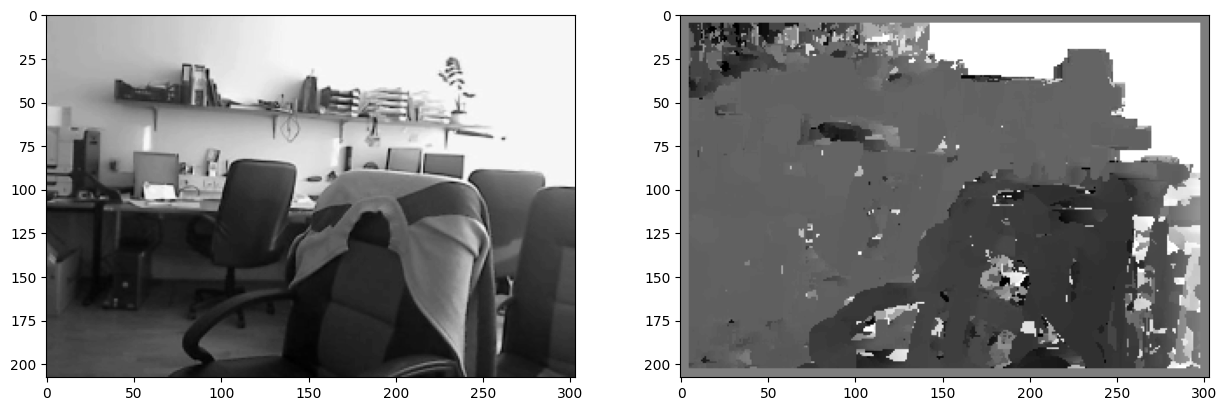

In [8]:
img_left = cv2.imread("data/disparity/office_left.png", cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread("data/disparity/office_right.png", cv2.IMREAD_GRAYSCALE)

height, width = img_left.shape[:2]
img_left = cv2.resize(img_left, (int(width * 0.5), int(height * 0.5)))
img_right = cv2.resize(img_right, (int(width * 0.5), int(height * 0.5)))

patch_size = 10

disparity_map = find_disparity(img_left, img_right, patch_size)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_left, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(disparity_map, cmap='gray')
plt.show()

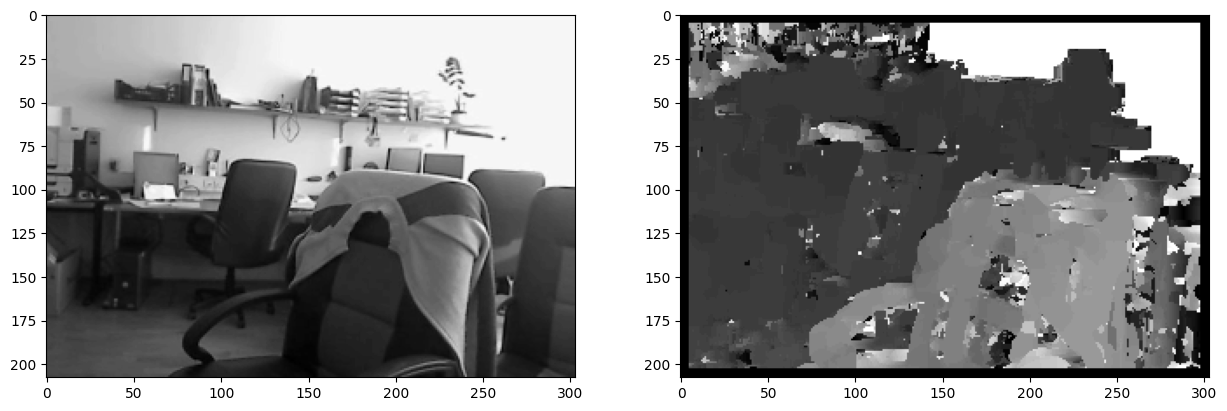

In [9]:
disparity_map = np.abs(disparity_map)
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_left, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(disparity_map, cmap='gray')
plt.show()

1 e

In [ ]:
def symetric_disparity(I,J, patch_size):
    dis1 = find_disparity(I,J,patch_size)
    dis2 = find_disparity(J,I,patch_size)

    return (dis1 + dis2) / 2

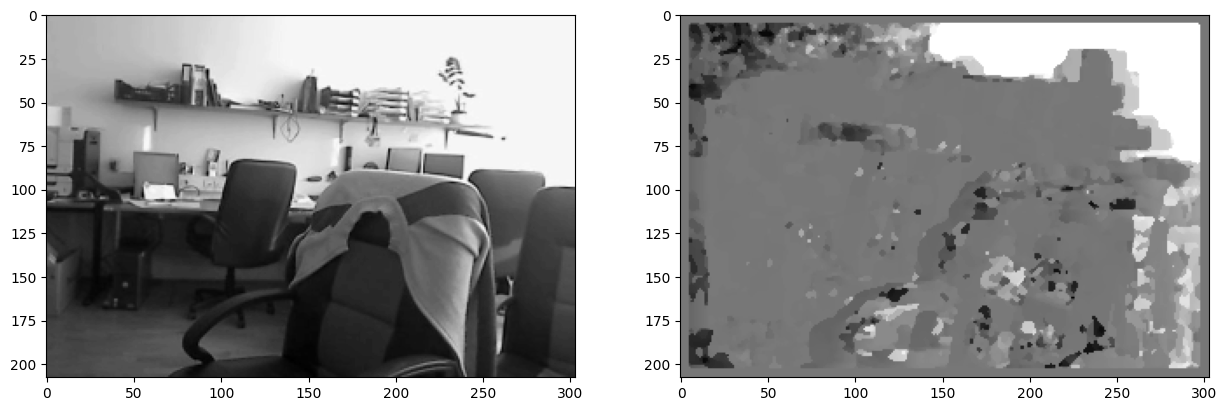

In [ ]:
sim_dis = symetric_disparity(img_left, img_right, patch_size)
sim_dis = cv2.medianBlur(sim_dis, 3)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_left, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(sim_dis, cmap='gray')
plt.show()

2 b

In [10]:
def read_points(file):
    data = file.read()
    data = data.split()
    data = np.array(data)
    data = np.copy(data.astype(np.float64))
    data = data.reshape((10, 4))
    pointsItemp = data[:, :2]
    pointsJtemp = data[:, -2:]
    pointsI = []
    pointsJ = []
    for i in range(0, 10):
        pointsI.append((pointsItemp[i][0], pointsItemp[i][1]))
        pointsJ.append((pointsJtemp[i][0], pointsJtemp[i][1]))
    return pointsI, pointsJ

In [11]:
def fundamental_matrix(points1, points2):

    A = np.zeros((len(points1), 9))

    #normalize points
    transformed1, T1 = normalize_points(np.array(points1))
    transformed2, T2 = normalize_points(np.array(points2))
    
    #fill A matrix
    for i in range(0, len(points1)):
        u1, v1, w1 = transformed1[i]
        u2, v2, w2 = transformed2[i]
        A[i] = [u1*u2, u1*v2, u1, v1*u2, v1*v2, v1, u2, v2, 1]

    #SVD
    U, D, Vt = np.linalg.svd(A)
    V = Vt.T

    #get last column of V
    f = V[:, -1]
    #print(f)
    #reshape to 3x3
    F = f.reshape((3, 3))

    #Decompose F
    U, D, Vt = np.linalg.svd(F)
    D = np.diag(D)
    D[-1] = 0
    #print(D)

    #reconstruct F
    F = np.dot(U, D)
    F = np.dot(F, Vt)
    
    #denormalize F
    F = np.dot(T2.T, F.T)
    F = np.dot(F, T1)
    #print(F)

    #get epipoles
    U, D, Vt = np.linalg.svd(F)
    V = Vt.T
    e1 = V[:, 2] / V[2, 2]
    e2 = U[:, 2] / U[2, 2]
    #print(e1, e2)

    return F, e1, e2

In [12]:
def drawEpipolarLines(points1,points2,F,e1,e2,I,J):
    plt.figure(figsize=(15,10))
    plt.subplot(1, 2, 1)
    plt.imshow(I, cmap="gray")

    for i in range(0, len(points1)):
        plt.plot(points1[i][0], points1[i][1], 'ro',markersize=4)
    h, w = I.shape

    for i in range(0, len(points2)):
        x = (points2[i][0], points2[i][1], 1)
        line = np.dot(F.T, x)
        draw_epiline(line, h, w)

    plt.subplot(1, 2, 2)
    plt.imshow(J, cmap="gray")
    h, w = J.shape

    for i in range(0, len(points2)):
        plt.plot(points2[i][0], points2[i][1], 'ro',markersize=4)
        
    for i in range(0, len(points1)):
        x = (points1[i][0], points1[i][1], 1)
        line = np.dot(F, x)
        draw_epiline(line, h, w)
    plt.show()

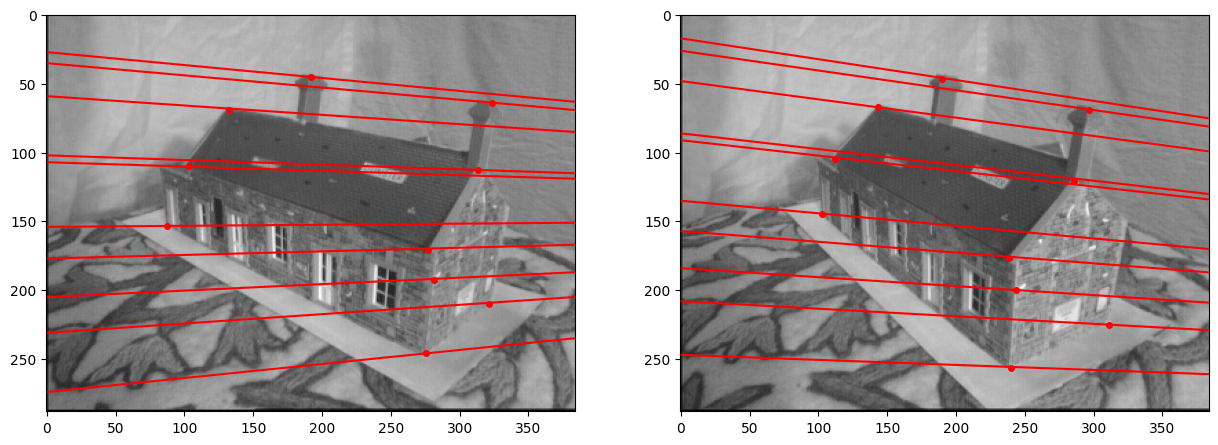

Fundamental Matrix:
[[-8.85211824e-07 -5.61591880e-06  1.94310952e-03]
 [ 9.39281870e-06  6.16883199e-07 -1.20066302e-02]
 [-1.20308414e-03  1.10370070e-02 -8.53173359e-02]]


In [ ]:
file = open('data/epipolar/house_points.txt', 'r')
points1, points2 = read_points(file)
file.close()

F, e1, e2= fundamental_matrix(points1, points2)

I = cv2.imread('data/epipolar/house1.jpg', cv2.IMREAD_GRAYSCALE)
J = cv2.imread('data/epipolar/house2.jpg', cv2.IMREAD_GRAYSCALE)

drawEpipolarLines(points1,points2,F,e1,e2,I,J)

print("Fundamental Matrix:")
print(F)

2 c

In [13]:
def reprojection_error(F, point1, point2):

    line1 = np.dot(F, point1)
    line2 = np.dot(F.T, point2)

    #calculate distance from point to line
    average = 0

    #line equation is ax + by + c = 0
    a1, b1, c1 = line1
    a2, b2, c2 = line2
    
    #calculate distance
    d1 = abs(a1*point2[0] + b1*point2[1] + c1) / np.sqrt(a1**2 + b1**2)
    d2 = abs(a2*point1[0] + b2*point1[1] + c2) / np.sqrt(a2**2 + b2**2)

    average = (d1 + d2) / 2

    return average

In [ ]:
point1 = (85, 233, 1)
point2 = (67, 219, 1)
average = reprojection_error(F, point1, point2)
print("average error of point 1 and 2: ", average)

length = len(points1)

#turn points into homogeneous coordinates
points1 = np.array(points1)
points2 = np.array(points2)
points1 = np.hstack((points1, np.ones((points1.shape[0], 1))))
points2 = np.hstack((points2, np.ones((points2.shape[0], 1))))

#calculate average error
average = 0
for i in range(0, length):
    average += reprojection_error(F, points1[i], points2[i])

average = average / length
print("average error: ", average)

average error of point 1 and 2:  0.14674365570482442
average error:  0.33091336980534647


2 d

In [14]:
def calculate_fundamental_matrix_ransac(keypoints1, keypoints2, matches, ransac_threshold=0.5, max_iterations=1000):
    # Convert points to homogeneous coordinates
    src_pts_homogeneous = np.float32([keypoints1[m.queryIdx].pt + (1,) for m in matches])
    dst_pts_homogeneous = np.float32([keypoints2[m.trainIdx].pt + (1,) for m in matches])

    best_F = None
    best_e1 = None
    best_e2 = None
    best_inliers = []
    max_inlier_count = 0

    for _ in range(max_iterations):
        # Randomly sample 8 points for fundamental matrix estimation
        random_indices = np.random.choice(len(matches), 8, replace=False)
        src_pts_sample = src_pts_homogeneous[random_indices]
        dst_pts_sample = dst_pts_homogeneous[random_indices]

        # Use the sampled points to estimate the fundamental matrix
        F, e1, e2 = fundamental_matrix(src_pts_sample[:, :2], dst_pts_sample[:, :2])

        # Calculate the point-to-line distances
        errors = np.array([reprojection_error(F, src_pt, dst_pt) for src_pt, dst_pt in zip(src_pts_homogeneous, dst_pts_homogeneous)])

        # Select inliers based on the threshold
        inliers = np.nonzero(errors < ransac_threshold)[0]
        inlier_count = len(inliers)

        if inlier_count > max_inlier_count:
            max_inlier_count = inlier_count
            best_F = F
            best_e1 = e1
            best_e2 = e2

            if inlier_count >= 8:
                #store the best inliers based on the error
                best_inliers = inliers[np.argsort(errors[inliers])[:8]]


    return best_F, best_e1 ,best_e2, best_inliers

In [15]:
def keypointsAndFundamentalCalculation(I,J):
    # Create SIFT detector
    detector = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = detector.detectAndCompute(I, None)
    keypoints2, descriptors2 = detector.detectAndCompute(J, None)
    # Use BFMatcher for matching
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Calculate fundamental matrix with RANSAC
    F,e1,e2,inliers = calculate_fundamental_matrix_ransac(keypoints1, keypoints2, good_matches)
    best_matches = [good_matches[i] for i in inliers]

    #print(len(best_matches))

    # Draw matches
    img_matches = cv2.drawMatches(I, keypoints1, J, keypoints2, best_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=4)

    # Display the matches
    plt.figure(figsize=(15, 10))
    plt.imshow(img_matches)
    plt.show()

    #cv2 to normal coordinates
    coordinates1 = [keypoints1[match.queryIdx].pt for match in best_matches]
    coordinates2 = [keypoints2[match.trainIdx].pt for match in best_matches]
    drawEpipolarLines(coordinates1,coordinates2,F,e1,e2,I,J)

    print("Fundamental Matrix:")
    print(F)
    
    #change coordinates to homogeneous
    coordinates1 = np.array(coordinates1)
    coordinates2 = np.array(coordinates2)
    coordinates1 = np.hstack((coordinates1, np.ones((coordinates1.shape[0], 1))))
    coordinates2 = np.hstack((coordinates2, np.ones((coordinates2.shape[0], 1))))

    #average error
    average = 0
    for i in range(0, len(coordinates1)):
        average += reprojection_error(F, coordinates1[i], coordinates2[i])
    
    average = average / len(coordinates1)

    print("average error: ", average)

    return F, coordinates1, coordinates2



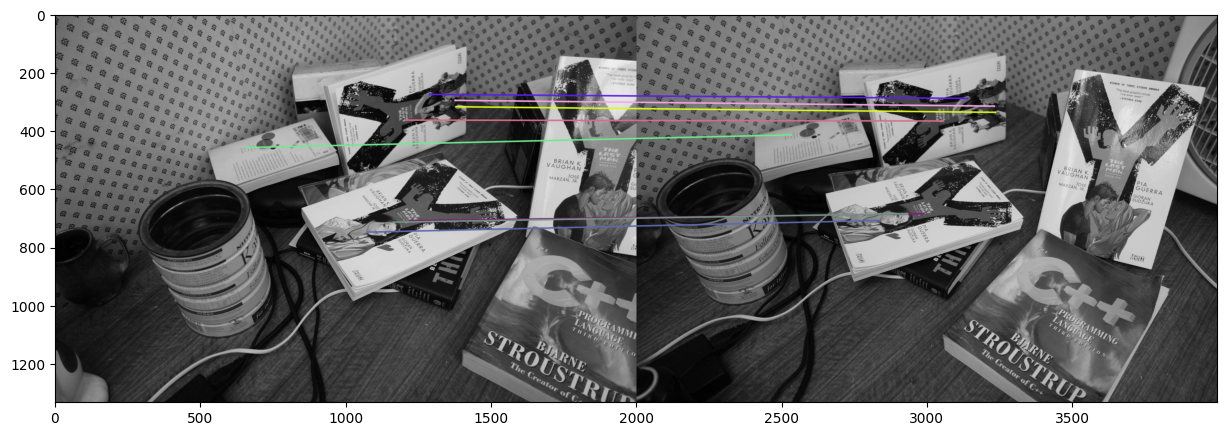

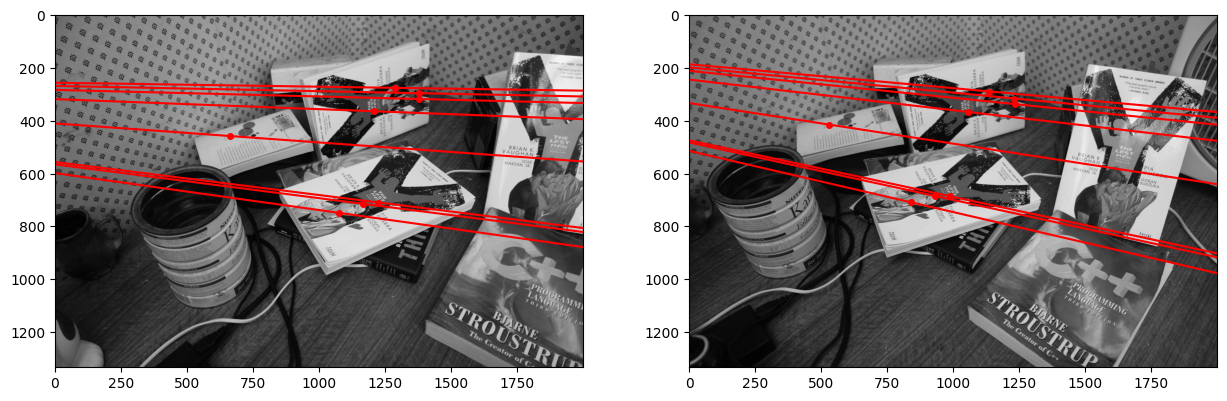

Fundamental Matrix:
[[ 3.25085280e-08  4.79686094e-07 -1.35138129e-05]
 [-4.40055195e-07  6.43169306e-08 -1.22170472e-03]
 [ 6.45897486e-05  1.12392760e-03 -6.34480689e-02]]
average error:  0.0011346793986551636


In [16]:
# Load images
I = cv2.imread('data/desk/DSC02638.jpg', cv2.IMREAD_GRAYSCALE)
J = cv2.imread('data/desk/DSC02639.jpg', cv2.IMREAD_GRAYSCALE)


F ,p1,p2 = keypointsAndFundamentalCalculation(I,J)

3 a

In [ ]:
def triangulation(points1,points2, C1, C2):

    #get fundamental matrix
    F = fundamental_matrix(points1, points2)

    results=[]
    for i in range(0, len(points1)):
        x1x = np.zeros((3, 3))
        x1x[0, 1] = -1
        x1x[0, 2] = points1[i][1]
        x1x[1, 0] = 1
        x1x[1, 2] = -points1[i][0]
        x1x[2, 0] = -points1[i][1]
        x1x[2, 1] = points1[i][0]

        x2x = np.zeros((3, 3))
        x2x[0, 1] = -1
        x2x[0, 2] = points2[i][1]
        x2x[1, 0] = 1
        x2x[1, 2] = -points2[i][0]
        x2x[2, 0] = -points2[i][1]
        x2x[2, 1] = points2[i][0]

        A = np.zeros((4, 4))
        A[0:2, :] = np.dot(x1x, C1)[0:2, :] # prve dve vrtice so za tocke v prvi kameri
        A[2:4, :] = np.dot(x2x, C2)[0:2, :] # druge dve za drugo

        #solve for X
        U, D, Vt = np.linalg.svd(A)
        V=Vt.T
        X = V[:, 3] / V[3, 3]

        results.append(X[:3])

    return results

In [ ]:
file = open('data/epipolar/house_points.txt')
points1, points2 = read_points(file)
file.close()

file = open('data/epipolar/house1_camera.txt')
camera1 = file.read().strip().split("\n")
C1 = np.zeros((3, 4))

for i in range(0, 3):
    #print(camera1[i].strip())
    #split by space (can have multiple spaces)
    h = camera1[i].split(" ")
    #remove empty strings
    h = list(filter(None, h))
    C1[i] = h

file.close()

file = open('data/epipolar/house2_camera.txt')
camera2 = file.read().strip().split("\n")
C2 = np.zeros((3, 4))

for i in range(0, 3):
    #split by space (can have multiple spaces)
    h= camera2[i].split(" ")
    #remove empty strings
    h = list(filter(None, h))
    C2[i] = h

file.close()

In [ ]:
results=triangulation(points1,points2, C1, C2)

T = np.array([[-1, 0, 0], [0, 0, 1], [0, -1, 0]])
results = np.dot(results, T)

In [ ]:
I = cv2.imread('data/epipolar/house1.jpg')
I = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
J = cv2.imread('data/epipolar/house2.jpg')
J = cv2.cvtColor(J, cv2.COLOR_RGB2GRAY)

x,y=zip(*points1)
plt.scatter(x,y, color='red', marker='o', label='Points')
for i, point in enumerate(points1):
    plt.annotate(str(i), (point[0], point[1]), textcoords="offset points", xytext=(5,5), ha='center')

plt.imshow(I, cmap="gray")
plt.show()

x,y=zip(*points2)
plt.scatter(x,y, color='red', marker='o', label='Points')
for i, point in enumerate(points2):
    plt.annotate(str(i), (point[0], point[1]), textcoords="offset points", xytext=(5,5), ha='center')

plt.imshow(J, cmap="gray")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(results[:, 0], results[:, 1], results[:, 2], c='b', marker='o')

# Plot the index of the point in 3D space
for i, (x, y, z) in enumerate(results):
    ax.text(x, y, z, str(i), color='red')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triangulated 3D Points')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 0.92, 'Triangulated 3D Points')

2 b

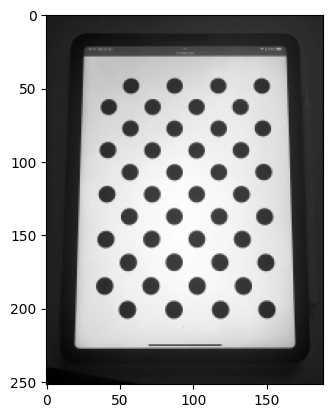

In [ ]:
calibration_pattern = cv2.imread('circles/IMG_9345.JPG')
gray_pattern = cv2.cvtColor(calibration_pattern, cv2.COLOR_BGR2GRAY)

height, width = gray_pattern.shape[:2]
gray_pattern = cv2.resize(gray_pattern, (int(width * 0.5), int(height * 0.5)))
height, width = gray_pattern.shape[:2]
gray_pattern = cv2.resize(gray_pattern, (int(width * 0.5), int(height * 0.5)))
height, width = gray_pattern.shape[:2]
gray_pattern = cv2.resize(gray_pattern, (int(width * 0.5), int(height * 0.5)))
height, width = gray_pattern.shape[:2]
gray_pattern = cv2.resize(gray_pattern, (int(width * 0.5), int(height * 0.5)))


plt.imshow(gray_pattern, cmap="gray")
plt.show()

# Define chessboard size
pattern_size = (4, 11)

params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 1
params.maxThreshold = 255
params.filterByArea = False
params.filterByInertia = False
params.filterByCircularity = False

detector = cv2.SimpleBlobDetector_create(params)

found, corners = cv2.findCirclesGrid(gray_pattern, pattern_size, flags = cv2.CALIB_CB_ASYMMETRIC_GRID + cv2.CALIB_CB_CLUSTERING,blobDetector=detector)

In [ ]:
found

False

In [ ]:
I = cv2.imread('IMG_9339.JPG', cv2.IMREAD_GRAYSCALE)
J = cv2.imread('IMG_9340.JPG', cv2.IMREAD_GRAYSCALE)

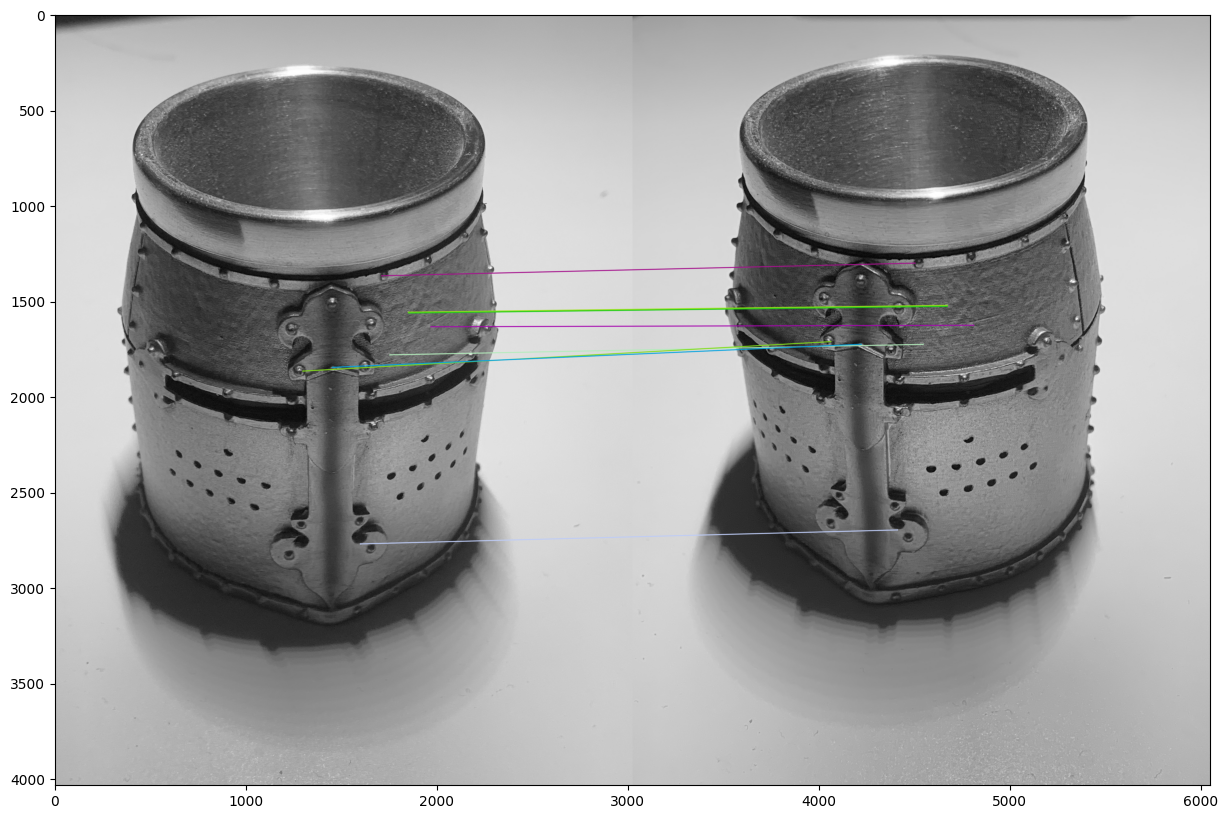

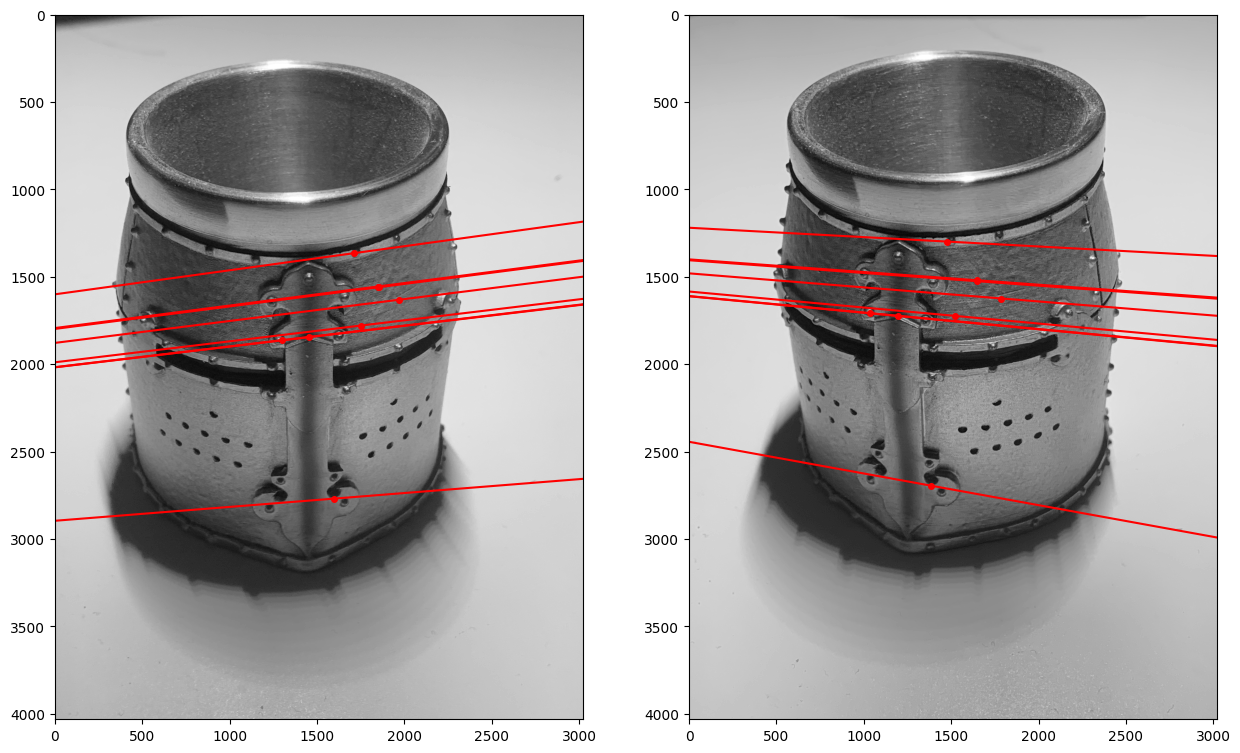

Fundamental Matrix:
[[ 2.40190131e-08  1.47925395e-07 -1.54997422e-04]
 [-6.68179167e-08  1.26081985e-08 -1.54678583e-03]
 [ 2.77949511e-04  1.41289196e-03 -3.99607472e-01]]
average error:  0.07184027754392552


In [ ]:
F, points1,points2 = keypointsAndFundamentalCalculation(I,J)

In [ ]:
E = np.dot(C1.T,F)
E = np.dot(E,C2)